In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
from cuml import ForestInference
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

In [2]:
config = f"""
execution:
    exp_id: exp_006
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs
    cand_exp_dir: /kaggle/output/exp_005

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [3]:
with open(os.path.join(CFG["dataset"]["cand_exp_dir"], "next_cands.pkl"), "rb") as f:
    next_cands = pickle.load(f)

## 特徴生成

In [4]:
def generate_features(train: pd.DataFrame):
    features = Features()

    # 時刻
    timestamp = pd.to_datetime(train["timestamp"].values[0])
    total_seconds = (timestamp - timestamp.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    train["total_seconds"] = (total_seconds + train.index * 5) % (24 * 60 * 60) # [sec]
    features.add_num_feature("total_seconds")    

    columns = ["anglez", "enmo"]

    # その人のその時刻での平均的な測定値
    gb = train.groupby("total_seconds")[columns].mean()
    gb.columns = [f"{c}_mean" for c in columns]
    train["anglez_mean"] = train["total_seconds"].map(gb["anglez_mean"])
    train["enmo_mean"] = train["total_seconds"].map(gb["enmo_mean"])
    features.add_num_features(gb.columns.tolist())
    columns += gb.columns.tolist()

    # diff
    f_names = [f"{c}_diff_abs" for c in columns]
    train[f_names] = train[columns].diff().abs()
    features.add_num_features(f_names)
    columns += f_names

    # rolling
    dts = [-1000, -100, -50, -10, 10, 50, 100, 1000]
    for dt in dts:            
        # rolling
        if dt > 0:
            f_names = [f"{c}_rolling_mean_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).mean()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_std_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).std()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_max_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).max()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_min_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).min()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_median_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).median()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_square_mean_{dt}" for c in columns]
            train[f_names] = ((train[columns] ** 2).rolling(dt, center=True).mean())
            features.add_num_features(f_names)


    # 一定stepで集約
    series_id = train["series_id"].values[0]
    agg_freq = CFG["feature"]["agg_freq"]
    columns = features.all_features() + ["target", "step"]
    train = train[columns].groupby(train["step"].values // agg_freq).mean()
    train["series_id"] = series_id
    train["target"] = train["target"].round().astype(int)

    # next_candsにないstepは除外
    cands = next_cands[series_id]
    train["reduce_step"] = train["step"].astype(int)
    train = train[train["reduce_step"].isin(cands)]

    train = reduce_mem_usage(train)
    gc.collect()
    return train, features

def read_and_generate_features(file):
    train = pd.read_csv(file)
    train, features = generate_features(train)
    return train, features

In [5]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.csv")

if CFG["execution"]["multiprocessing"]:
    with Pool(30) as pool:
        results = list(tqdm(pool.imap(read_and_generate_features, files), total=len(files)))
    dfs, features = zip(*results)
    train = pd.concat(dfs)
    features = features[0]
else:
    dfs = []
    for file in tqdm(files):
        train = pd.read_csv(file)
        train, features = generate_features(train)
        dfs.append(train)
    train = pd.concat(dfs)
    features = features[0]

100%|██████████| 277/277 [06:26<00:00,  1.39s/it]


## 学習

In [6]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train = train.merge(cv_split, on=["series_id"], how="left")
display(train.head(5))
train.shape

,anglez_diff_abs,anglez_diff_abs_rolling_max_10,anglez_diff_abs_rolling_max_100,anglez_diff_abs_rolling_max_1000,anglez_diff_abs_rolling_max_50,anglez_diff_abs_rolling_mean_10,anglez_diff_abs_rolling_mean_100,anglez_diff_abs_rolling_mean_1000,anglez_diff_abs_rolling_mean_50,anglez_diff_abs_rolling_median_10,...,enmo_rolling_std_10,enmo_rolling_std_100,enmo_rolling_std_1000,enmo_rolling_std_50,total_seconds,target,step,series_id,reduce_step,fold
0,8.583371,24.031192,51.115900,84.6226,38.845308,8.420339,10.798342,8.294370,10.350743,6.356337,...,0.063609,0.119329,0.115207,0.065778,74397.5,1,6779.5,af91d9a50547,6779,2
1,16.702658,38.064583,51.115900,84.6226,51.115900,15.962638,11.263916,8.043460,12.792510,14.257165,...,0.057544,0.216759,0.110767,0.135991,74517.5,1,6803.5,af91d9a50547,6803,2
2,7.195825,28.564683,51.115900,84.6226,51.115900,8.541195,12.527601,7.737612,12.364961,6.165692,...,0.237268,0.212448,0.103912,0.279359,74637.5,1,6827.5,af91d9a50547,6827,2
3,16.351179,34.583987,51.115900,84.6226,40.295400,15.494380,12.499973,7.288104,12.204054,14.248077,...,0.134445,0.214842,0.100219,0.251339,74757.5,1,6851.5,af91d9a50547,6851,2
4,10.855896,32.284983,42.890471,84.6226,38.495083,10.967216,12.269771,6.938846,12.743385,6.737581,...,0.041026,0.198442,0.098054,0.063669,74877.5,1,6875.5,af91d9a50547,6875,2


(690297, 204)

In [7]:
if CFG['execution']['submit']:
    # 推論
    models = [
        ForestInference.load(
            os.path.join(CFG["model_dir"], f'xgb_fold{i}.model'),
            output_class=True,
            model_type='xgboost'
        ) for i in range(CFG.n_fold)]
    pred = inference_xgb(models, train[features])
else:
    # 学習
    trn_oof, models = fit_xgb(train[features.all_features()], train["target"], train["fold"].astype(
        int), params=CFG["xgboost"], es_rounds=50)
    train["oof"] = trn_oof

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-logloss:0.65771
[50]	eval-logloss:0.40781
[100]	eval-logloss:0.39496
[150]	eval-logloss:0.39366
[200]	eval-logloss:0.39396
[209]	eval-logloss:0.39346


 20%|██        | 1/5 [01:12<04:48, 72.23s/it]

== fold 1 ==
[0]	eval-logloss:0.65657
[50]	eval-logloss:0.39600
[100]	eval-logloss:0.38316
[150]	eval-logloss:0.37700
[200]	eval-logloss:0.37423
[250]	eval-logloss:0.37286
[300]	eval-logloss:0.37229
[321]	eval-logloss:0.37239


 40%|████      | 2/5 [02:56<04:33, 91.01s/it]

== fold 2 ==
[0]	eval-logloss:0.65598
[50]	eval-logloss:0.39192
[100]	eval-logloss:0.38708
[133]	eval-logloss:0.38834


 60%|██████    | 3/5 [03:41<02:20, 70.26s/it]

== fold 3 ==
[0]	eval-logloss:0.65531
[50]	eval-logloss:0.39618
[100]	eval-logloss:0.39337
[147]	eval-logloss:0.39717


 80%|████████  | 4/5 [04:29<01:01, 61.11s/it]

== fold 4 ==
[0]	eval-logloss:0.65782
[50]	eval-logloss:0.41607
[100]	eval-logloss:0.40416
[150]	eval-logloss:0.39813
[200]	eval-logloss:0.39608
[250]	eval-logloss:0.39506
[300]	eval-logloss:0.39517
[322]	eval-logloss:0.39543


100%|██████████| 5/5 [06:10<00:00, 74.09s/it]


In [8]:
train = train.drop(columns=features.all_features())
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)
train["STAGE"] = 2

In [12]:
last_train = pd.read_csv(os.path.join(CFG["dataset"]["cand_exp_dir"], "oof.csv"))
last_train.head()

,target,step,series_id,fold,oof
0,1,11.5,038441c925bb,2,0.998872
1,1,35.5,038441c925bb,2,0.998753
2,1,59.5,038441c925bb,2,0.991332
3,1,83.5,038441c925bb,2,0.990948
4,1,107.5,038441c925bb,2,0.990733


In [16]:
train = last_train.merge(train[["series_id", "oof", "STAGE", "step"]], on=["series_id", "step"], how="left", suffixes=("_stage1", "_stage2"))
train["oof"] = train["oof_stage2"].fillna(train["oof_stage1"])
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)
train[~train["STAGE"].isna()]

,target,step,series_id,fold,oof_stage1,oof_stage2,STAGE,oof
195,1,4691.5,038441c925bb,2,0.997191,0.993935,2.0,0.993935
196,1,4715.5,038441c925bb,2,0.997545,0.993858,2.0,0.993858
197,1,4739.5,038441c925bb,2,0.996836,0.993935,2.0,0.993935
198,1,4763.5,038441c925bb,2,0.995554,0.992815,2.0,0.992815
199,1,4787.5,038441c925bb,2,0.994861,0.991460,2.0,0.991460
...,...,...,...,...,...,...,...,...
5331147,1,592019.5,fe90110788d2,2,0.983103,0.950632,2.0,0.950632
5331148,1,592043.5,fe90110788d2,2,0.983103,0.950632,2.0,0.950632
5331149,1,592067.5,fe90110788d2,2,0.983103,0.950632,2.0,0.950632
5331150,1,592091.5,fe90110788d2,2,0.983103,0.950632,2.0,0.950632


## 予測値の作成

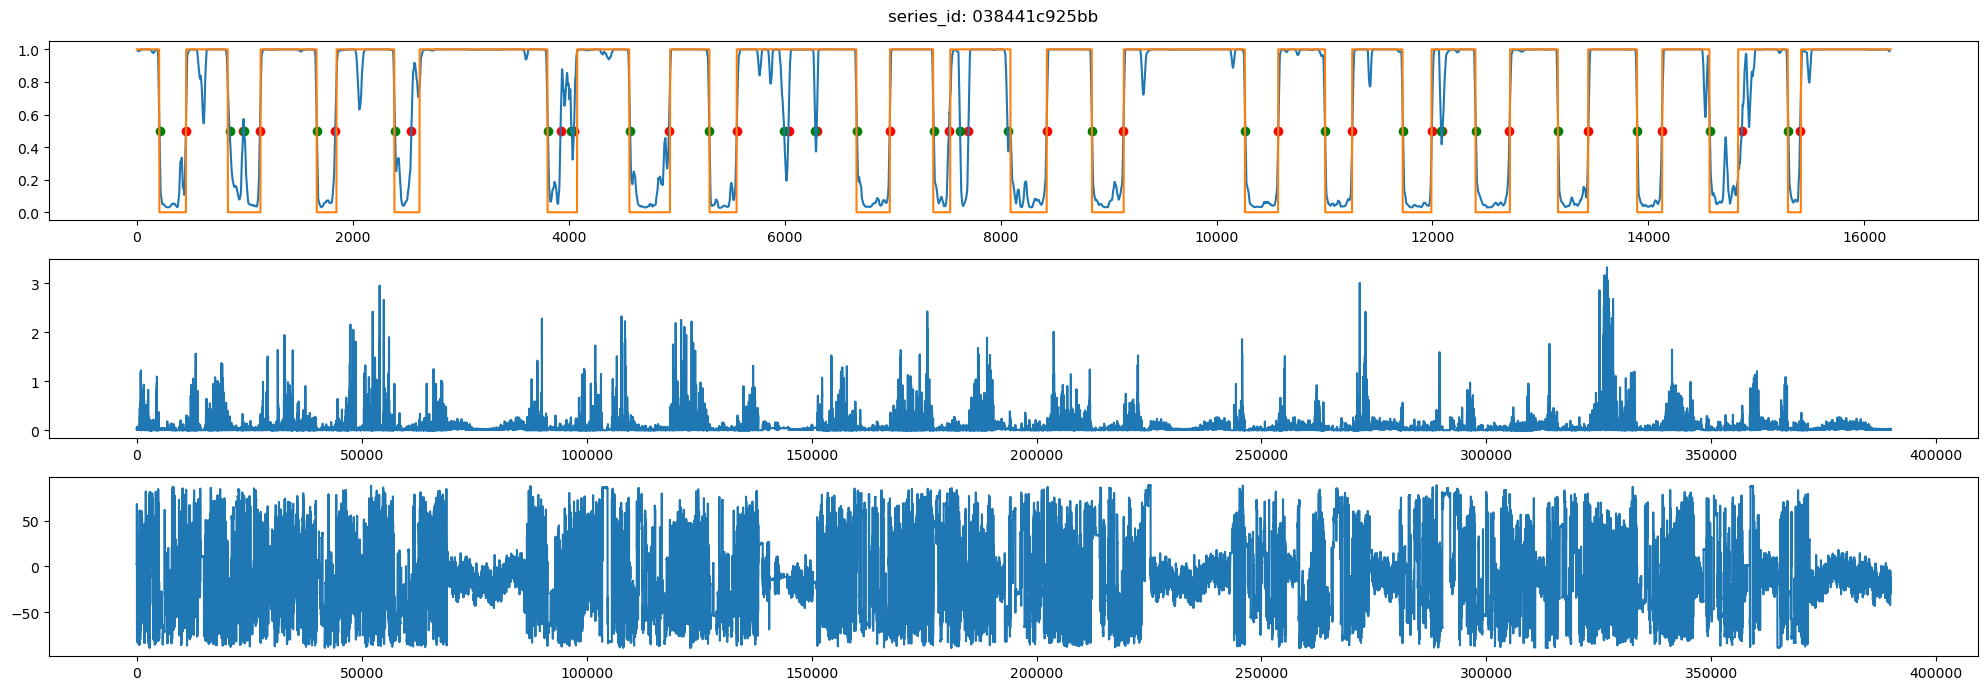

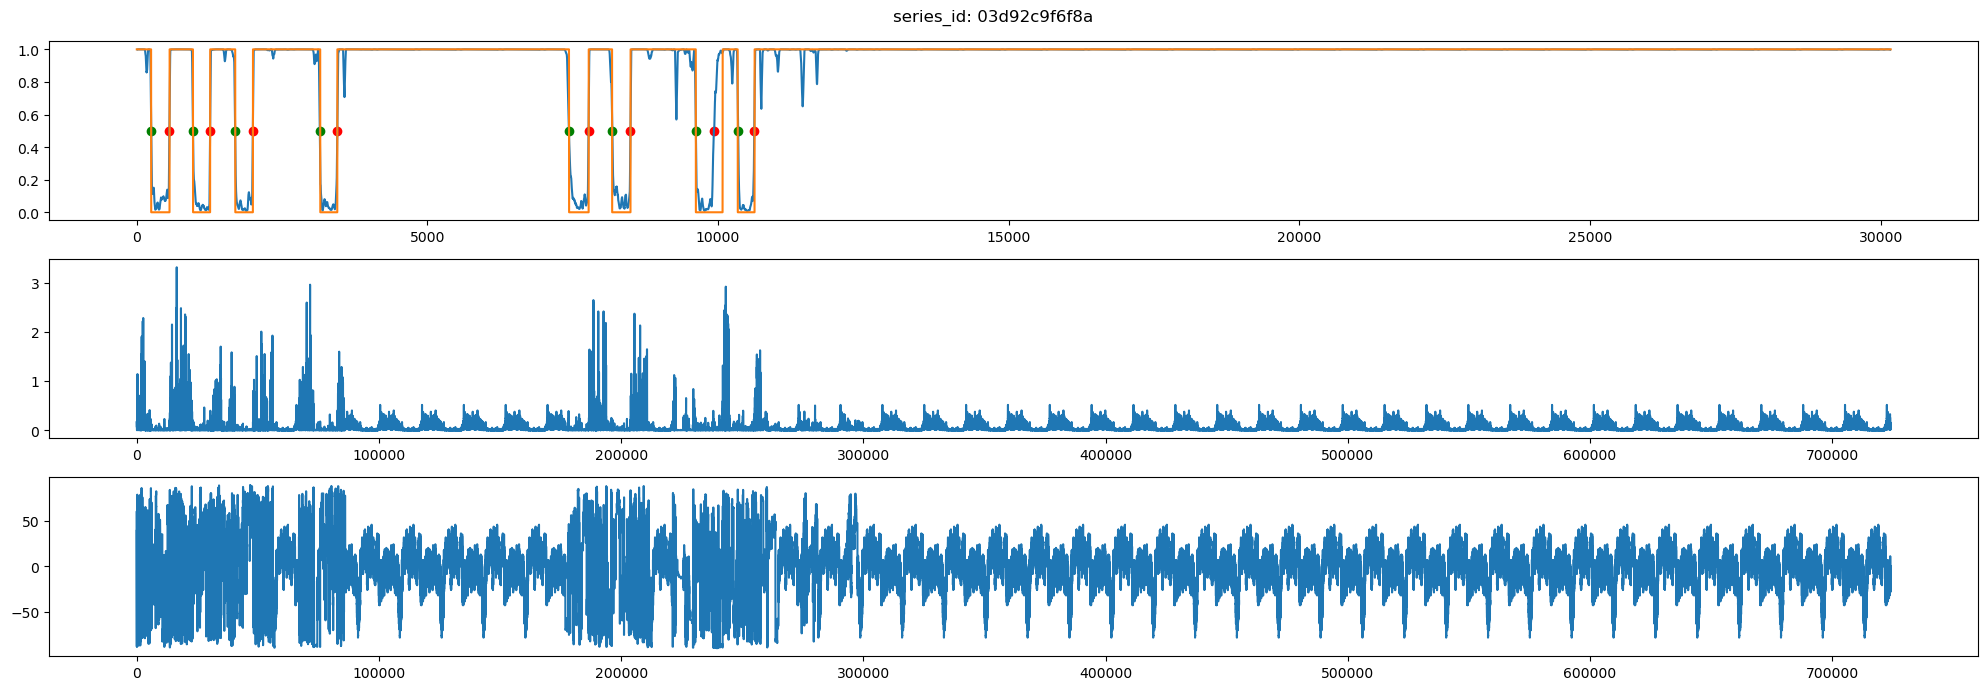

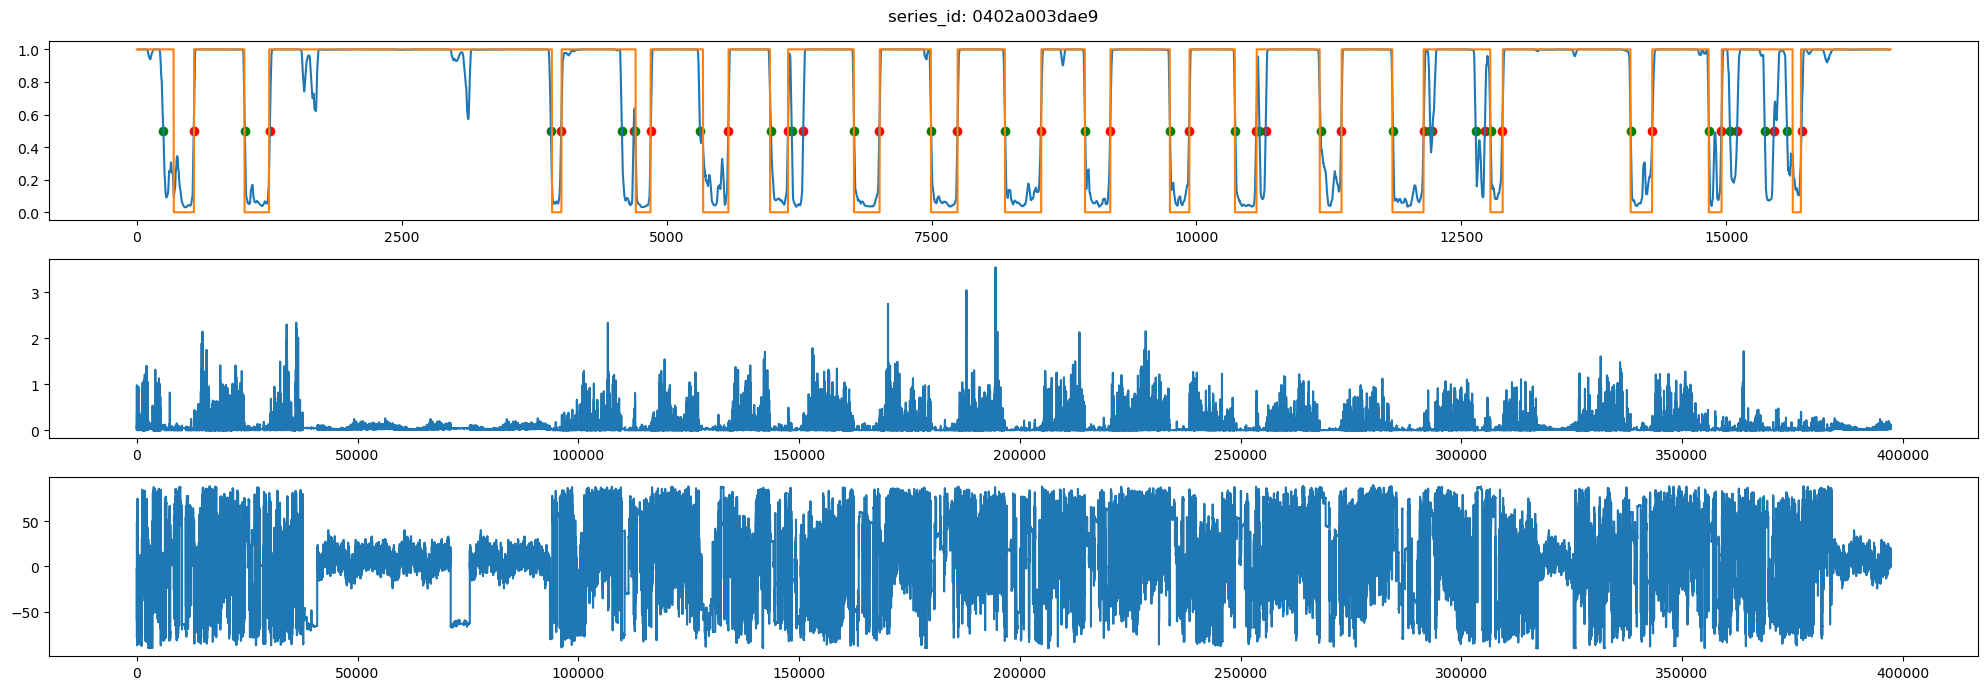

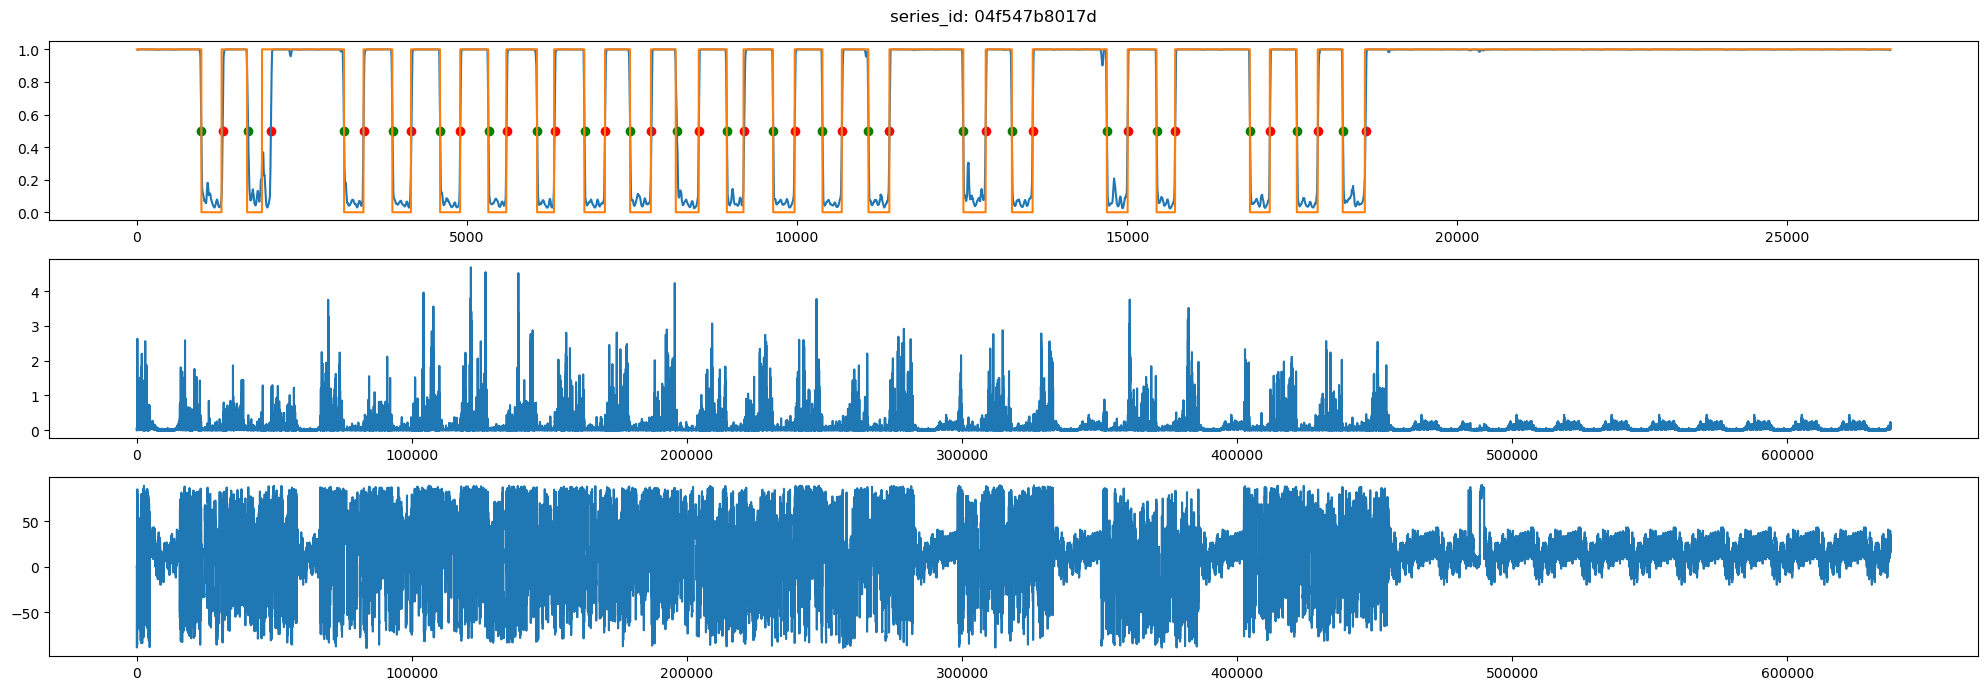

,series_id,step,event,score
0,038441c925bb,10895,wakeup,1
1,038441c925bb,23639,wakeup,1
2,038441c925bb,27359,wakeup,1
3,038441c925bb,44111,wakeup,1
4,038441c925bb,61031,wakeup,1


In [19]:
dfs = []
for series_id, df in train.groupby("series_id"):
    df = df.reset_index(drop=True)
    oof = df["oof"].rolling(24, center=True).mean()
    wakeup_index = np.array([i for i in range(1, len(oof)) if oof[i-1] < 0.5 and oof[i] >= 0.5])
    onset_index = np.array([i for i in range(1, len(oof)) if oof[i-1] > 0.5 and oof[i] <= 0.5])

    sub = pd.concat([
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[wakeup_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "wakeup",
            "score": 1,
        }) if len(wakeup_index) > 0 else pd.DataFrame(),
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[onset_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "onset",
            "score": 1,
        }) if len(onset_index) > 0 else pd.DataFrame(),
    ])
    if len(sub) > 0:
        sub["step"] = sub["step"].astype(int)
        dfs.append(sub)

    if len(dfs) < 5:
        fig, axs = plt.subplots(3, 1, figsize=(20, 7))
        axs[0].plot(oof)
        axs[0].plot(df["target"])
        axs[0].scatter(wakeup_index, [0.5 for _ in wakeup_index], c="red")
        axs[0].scatter(onset_index, [0.5 for _ in onset_index], c="green")
        df = pd.read_csv(f"{CFG['dataset']['step_csv_dir']}/{df['series_id'].values[0]}.csv")
        axs[1].plot(df["enmo"])
        axs[2].plot(df["anglez"])
        plt.suptitle(f"series_id: {series_id}")
        plt.tight_layout()
        plt.show()

sub = pd.concat(dfs).reset_index(drop=True)
sub.head()

score: 0.3788


event   tolerance
onset   12           0.003106
        36           0.032081
        60           0.100866
        90           0.216593
        120          0.371225
        150          0.441743
        180          0.511969
        240          0.581672
        300          0.620979
        360          0.640816
wakeup  12           0.007254
        36           0.070328
        60           0.183887
        90           0.334842
        120          0.426427
        150          0.501251
        180          0.556251
        240          0.625263
        300          0.661433
        360          0.687451
dtype: float64

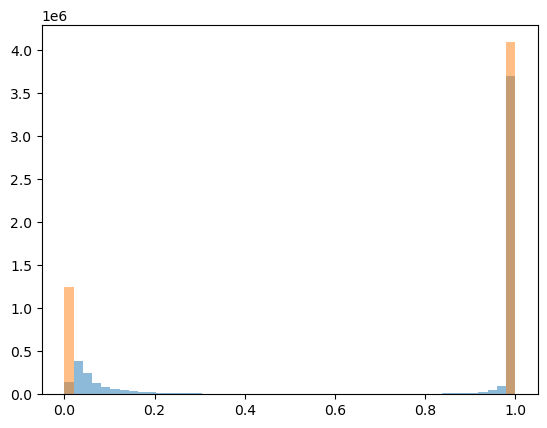

In [20]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)
plt.hist(train["oof"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.show()

In [22]:
# 次の候補の大きさ
next_cand_size = 0
count = 0
next_dict = {}
for series_id, train_df in train.groupby("series_id"):
    train_df = train_df[(train_df["oof"] >= 0.1) & (train_df["oof"] <= 0.9)]
    sub_df = sub[(sub["series_id"] == series_id)]
    label_df = labels[labels["series_id"] == series_id]
    pred_steps = train_df["step"].values
    sub_steps = sub_df["step"].values
    label_steps = label_df["step"].values

    if len(train_df) == 0:
        continue
    next_cand = np.zeros(int(max(max(pred_steps if len(pred_steps) > 0 else [0]), max(sub_steps if len(sub_steps) > 0 else [0]))) + CFG["feature"]["agg_freq"])
    for sub_step in sub_steps:
        next_cand[int(sub_step - CFG["feature"]["agg_freq"] * 5): int(sub_step + CFG["feature"]["agg_freq"] * 5)] = 1
    for pred_step in pred_steps:
        next_cand[int(pred_step - CFG["feature"]["agg_freq"] * 5): int(pred_step + CFG["feature"]["agg_freq"] * 5)] = 1
    next_cand_size += np.sum(next_cand)
    next_dict[series_id] = np.where(next_cand)[0]

    for label_step in label_steps:
        if label_step < next_cand.shape[0]:
            count += next_cand[int(label_step)]
    
recall = count / len(labels)
print(f"recall: {recall:.4f}")
print(f"next_cand_size: {next_cand_size}")

recall: 0.9658
next_cand_size: 17236284.0


In [23]:
import pickle

with open(f"{CFG['output_dir']}/next_cands.pkl", "wb") as f:
    pickle.dump(next_dict, f)